In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [12]:
from xgboost import XGBRegressor, DMatrix, train
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, r2_score,
    mean_absolute_error, accuracy_score,
    f1_score, roc_auc_score,
    log_loss
)

In [3]:
MTU = 1514
MB = 1024 * 1024
KB = 1024
GB = 1024 * 1024 * 1024
SECONDS = 1e9
MILLI_SECONDS = 1e6
MICRO_SECONDS = 1e3
NANO_SECONDS = 1
IPS = [222, 116]
MASTER = 222
TARGET_IP = 116

RES = 200
TIMERES = 'Milliseconds'
TIMERESL = 'm'

In [4]:
ts = pd.read_csv('../data/cellar/croston.csv')
ts['timestamp'] = (ts['timestamp'] - ts['timestamp'].min()) / ts['timestamp'].max()
ts['size'] = ts['size'] / ts['size'].max()

In [5]:
def prepare_files(df, window_size, target_column='size'):
    target = df[target_column]
    final_df = df.copy()
    for sample_num in range(1, window_size):
        shifted = df.shift(sample_num)
        shifted.columns = map(lambda x: x+str(sample_num), shifted.columns)
        final_df = pd.concat([shifted, final_df], axis=1)
    final_df = final_df.fillna(0)
    final_df = final_df.drop(target_column, axis=1)
    return final_df, target

In [6]:
def smape(real, prediction):    
    epsilon = 0.1  # Smoothing factor, helps SMAPE to be well-behaved near zero
    true_o = real # np.expm1(real)
    pred_o = prediction # np.expm1(prediction)
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ * 2.0
    return np.sum(smape)

In [7]:
def eval_metrics(real, prediction):
    mse = mean_squared_error(real, prediction)
    mae = mean_absolute_error(real, prediction)
    r2 = r2_score(real, prediction)
    mape = mean_absolute_percentage_error(real, prediction)
    ss = smape(real, prediction)

    return {'mse': mse, 'mae': mae, 'r2': r2, 'smape': ss}

In [8]:
def eval_model(model, xtest, ytest):
    y_pred = model.predict(xtest)
    return eval_metrics(ytest, y_pred)

In [62]:
def xgboost_learn(xtrain, ytrain, xtest, ytest):
    model = XGBRegressor(objective='reg:squarederror', 
                         n_estimators=200, 
                         max_depth=15, 
                         eval_metric=r2_score, 
                         booster='gbtree',
                        )
    model.fit(xtrain, ytrain)
    result = {}
    result['train'] = eval_model(model, xtrain, ytrain)
    result['test'] = eval_model(model, xtest, ytest)

    return result, model

In [63]:
def get_score(df, features, window_size=256, split=0.5):
    scaler = MinMaxScaler().fit(df[features])
    df[features] = scaler.transform(
        df[features]
    )
    df_t = df[features]
    inputs, outputs = prepare_files(df_t, window_size)
    x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=split, shuffle=False)
    r, _ = xgboost_learn(x_train, y_train, x_test, y_test)
    return r['train'], r['test']

In [64]:
get_score(ts, ['timestamp', 'size'])

({'mse': 9.82293141783475e-08,
  'mae': 0.00022924161154133088,
  'r2': 0.9999978129180815,
  'smape': 0.9131348197428992},
 {'mse': 0.027086179351093902,
  'mae': 0.10751714338917678,
  'r2': 0.3868824023429057,
  'smape': 442.21914786849686})

In [61]:
split = 0.2
metric = 'smape'
def get_scores(features):
    times = list(range(200, 3000, 250))
    train_scores = []
    test_scores = []
    for r in times:
        df = pd.read_csv(f'ts_{r}.csv')
        df = df[features]
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
#         for c in df.columns:
#             mean = df[c].mean()
#             stdev = df[c].std()
#             df[c] = (df[c] - mean) / stdev
#             df[c] = (df[c] - mean) / stdev
#             df[c] = df[c] - df[c][:int(len(df) * (1 - split))].min()
        inputs, outputs = prepare_files(df, 100)
        x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=split, shuffle=False)
        r, _ = xgboost_learn(x_train, y_train, x_test, y_test)
        train_scores += [r['train']]
        test_scores += [r['test']]
    return train_scores, test_scores, times

train_scores, test_scores, times = get_scores(['timestamp', 'size'])
train_scores_wa, test_scores_wa, times = get_scores(['timestamp', 'size', 'allocs'])

FileNotFoundError: [Errno 2] No such file or directory: 'ts_200.csv'

In [38]:
metric = 'mse'
ttrain_scores = [t[metric] for t in train_scores]
ttest_scores = [t[metric] for t in test_scores]
ttrain_scores_wa = [t[metric] for t in train_scores_wa]
ttest_scores_wa = [t[metric] for t in test_scores_wa]

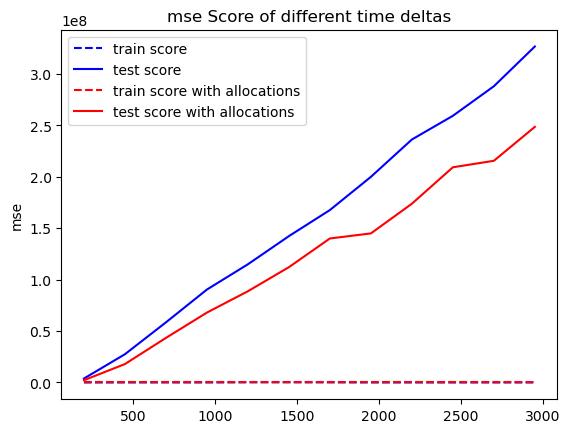

In [39]:
plt.ylabel(metric)
plt.title(f"{metric} Score of different time deltas")
plt.plot(times, ttrain_scores, 'b--', label='train score')
plt.plot(times, ttest_scores, 'b-', label='test score')
plt.plot(times, ttrain_scores_wa, 'r--', label='train score with allocations')
plt.plot(times, ttest_scores_wa, 'r-', label='test score with allocations')
plt.legend(loc='best')
plt.show()

RES = 2000
({'train': {'mse': 2213857.391212464,
   'mae': 730.6404319857144,
   'r2': 0.7279064089400382},
  'test': {'mse': 2693812.8702931516,
   'mae': 815.724213257461,
   'r2': 0.6574755396638999}},

RES = 200 ResNet NCCL
'train': {'mse': 9.101269742950386e-07,
  
({'train': {'mse': 2.9009046081819423e-07,
   'mae': 0.00011134981196798435,
   'r2': 0.7098828104436443},
  'test': {'mse': 3.43119514130418e-07,
   'mae': 0.00012053085141676116,
   'r2': 0.6566614615364892}}

RES = 200 GPT C20D
({'train': {'mse': 3.222166312277829e-07,
   'mae': 0.00012348057231785167,
   'r2': 0.6816371602112872},
  'test': {'mse': 3.7919567986376153e-07,
   'mae': 0.0001340097186057974,
   'r2': 0.6124819743566556}}

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset

In [5]:
split = 0.2
target = 'target'
features = ['timestamp', 'size']
ts = pd.read_csv('ts.csv')
ts = ts.apply(pd.to_numeric)
ts[target] = ts['size'].shift(-1)
ts = ts[:-1]
split_index = int(ts.shape[0] * split)
df_train = ts[:-split_index]
df_test = ts[-split_index:]

In [6]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

/tmp/ipykernel_1599457/362411511.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[c] = (df_train[c] - mean) / stdev
/tmp/ipykernel_1599457/362411511.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[c] = (df_test[c] - mean) / stdev


In [7]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [8]:
torch.manual_seed(101)

batch_size = 128
sequence_length = 256

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([128, 256, 2])
Target shape: torch.Size([128])


In [9]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [10]:
learning_rate = 5e-5
num_hidden_units = 64

model = ShallowRegressionLSTM(num_features=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0
    y_pred = []
    y_real = []

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()
            y_pred.extend(output.numpy())
            y_real.extend(y.numpy())

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    print(f"R2 score: {r2_score(y_real, y_pred)}")

In [12]:
print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(50):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.7408003109454546
R2 score: -0.0005024017488926003

Epoch 0
---------
Train loss: 0.9985583321593031
Test loss: 0.7417137985521892
R2 score: -0.0015748372768931151

Epoch 1
---------
Train loss: 0.9958147686416221
Test loss: 0.7391251804974844
R2 score: 0.0019512080927062136

Epoch 2
---------
Train loss: 0.9788602119161619
Test loss: 0.8498410056784468
R2 score: -0.142680716002471

Epoch 3
---------
Train loss: 0.9297313350230738
Test loss: 1.1094162059280108
R2 score: -0.48322620882713707

Epoch 4
---------
Train loss: 0.8905216580106748
Test loss: 1.2065608349611174
R2 score: -0.6101315548350885

Epoch 5
---------
Train loss: 0.8327012336084628
Test loss: 1.1096668083150432
R2 score: -0.47915435502199166

Epoch 6
---------
Train loss: 0.7734696336302429
Test loss: 0.5638902192267606
R2 score: 0.23848834112155004

Epoch 7
---------



KeyboardInterrupt



In [ ]:
test_model(test_loader, model, loss_function)

RES = 200 ResNet NCCL
Test loss: 0.6859737798425152
R2 score: 0.3139429240444592

RES = 200 GPT C20D
Test loss: 0.3235129721796335
R2 score: 0.6663728481527116